In [4]:
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import pandas as pd
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL.PngImagePlugin")


In [4]:
data_dir = 'emotion_data'

In [5]:
img_ext = ['jpeg','jpg','bmp','png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        img_path = os.path.join(data_dir,image_class,image)
        
        try:
            img = cv2.imread(img_path) # Read image as numpy array
            tip = imghdr.what(img_path) # Get File Extension
            if tip not in img_ext:
                print("Image is not in: {}".format(img_path))
                os.remove(img_path)
        except Exception as e:
            print("Issue with image {}".format(img_path))

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


# Load Dataset 

In [7]:
# Building Data Pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 481 files belonging to 3 classes.


In [8]:
# CLASS 0 - Happy People
# CLASS 1 - Neutral People
# CLASS 2 - Sad People
data.class_names

['Happy', 'Neutral', 'Sad']

In [9]:
# Allowing Dataset to loop through 
data_iterator = data.as_numpy_iterator()

In [10]:
# Access Data from Data Pipeline
batch = data_iterator.next()

2023-12-19 15:20:50.622776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:50.683922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:20:50.794713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:50.830850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [11]:

len(batch[1])

32

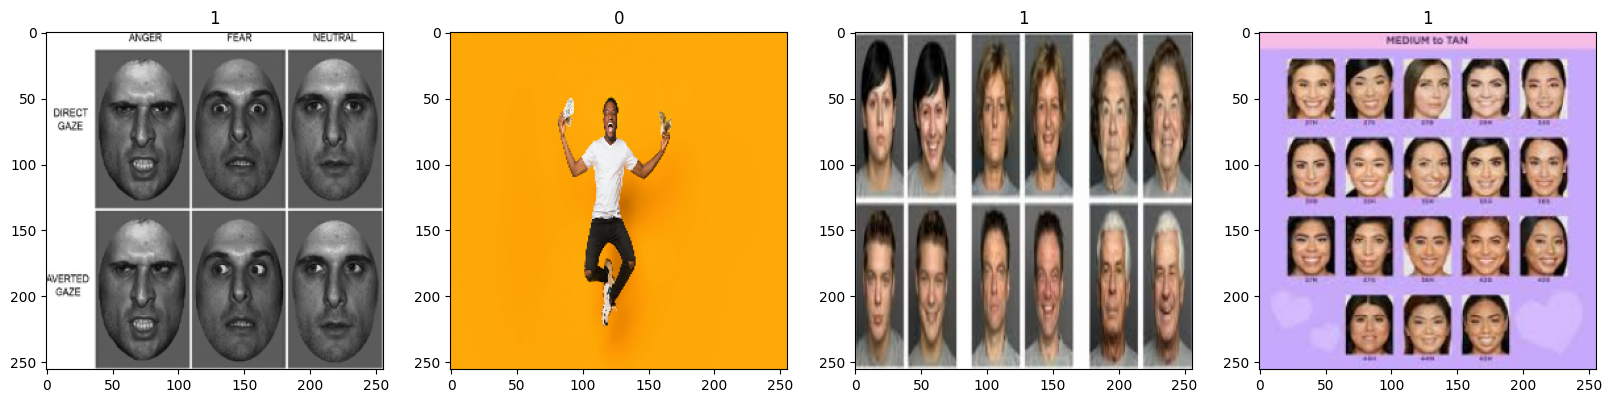

In [12]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

 # Preprocess Data

In [13]:
data = data.map(lambda x, y: (x/255, y))

In [14]:
scaled_iterator = data.as_numpy_iterator()

In [15]:
scaled_iterator.next()[0].min()

2023-12-19 15:20:51.991193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:52.050846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:20:52.166320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:52.202638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


0.0

In [16]:
batch = scaled_iterator.next()

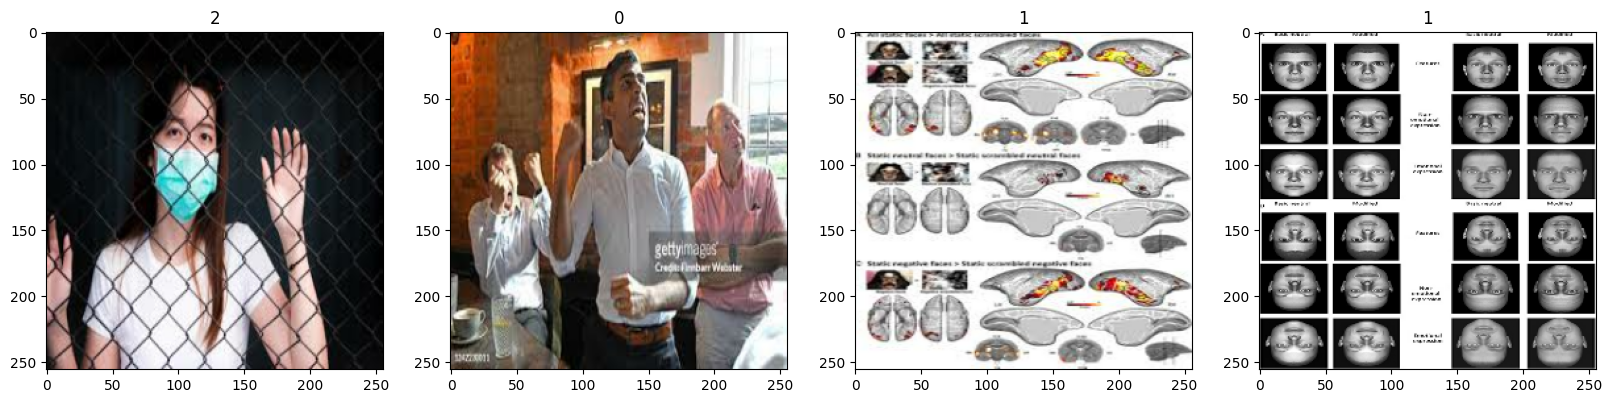

In [17]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [18]:
len(data)

16

In [19]:
# Split Dataset

train_size = int(len(data) * .7)
val_size = int(len(data) * .2)+1
test_size = int(len(data) * .1)+1

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [21]:
abc = train.as_numpy_iterator()
abc = abc.next()
abc[0].shape

2023-12-19 15:20:53.802038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:53.861756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:20:53.976871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:54.008497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


(32, 256, 256, 3)

In [22]:
len(test)

1

# Deep Model

In [23]:
# Build Deep Neural Network
model = Sequential()

model.add(Conv2D(filters=16,kernel_size= (3,3),strides = 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3),1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(3, activation="softmax"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [25]:
model.compile('adam', loss = "sparse_categorical_crossentropy", metrics=['accuracy'])

In [26]:
logs_dir = 'logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-12-19 15:20:55.510852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:55.573836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:20:55.674952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:55.706953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 1.6864 - accuracy: 0.4432

2023-12-19 15:20:59.207371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:59.272552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:20:59.374945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:20:59.408092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 7s 528ms/step - loss: 1.6864 - accuracy: 0.4432 - val_loss: 1.0517 - val_accuracy: 0.5078
Epoch 2/20


2023-12-19 15:21:01.791652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:01.850215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:01.951926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:01.988777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 1.0289 - accuracy: 0.5227

2023-12-19 15:21:05.195932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:05.256630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:05.367519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:05.401385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 393ms/step - loss: 1.0289 - accuracy: 0.5227 - val_loss: 1.0410 - val_accuracy: 0.4688
Epoch 3/20


2023-12-19 15:21:06.611502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:06.674596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:06.778810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:06.808317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 1.0017 - accuracy: 0.5227

2023-12-19 15:21:10.125973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:10.186902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:10.304220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:10.339399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 408ms/step - loss: 1.0017 - accuracy: 0.5227 - val_loss: 0.9791 - val_accuracy: 0.5078
Epoch 4/20


2023-12-19 15:21:11.591781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:11.652115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:11.760985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:11.799640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.9014 - accuracy: 0.6080

2023-12-19 15:21:15.003365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:15.070265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:15.178782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:15.213393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 389ms/step - loss: 0.9014 - accuracy: 0.6080 - val_loss: 0.8886 - val_accuracy: 0.5859
Epoch 5/20


2023-12-19 15:21:16.385745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:16.445061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:16.551728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:16.582479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.6619

2023-12-19 15:21:19.742558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:19.804608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:19.910798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:19.947246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 387ms/step - loss: 0.7858 - accuracy: 0.6619 - val_loss: 0.7265 - val_accuracy: 0.6641
Epoch 6/20


2023-12-19 15:21:21.131301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:21.190306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:21.293293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:21.326442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.7131

2023-12-19 15:21:24.617048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:24.678726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:24.793139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:24.823467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 399ms/step - loss: 0.6958 - accuracy: 0.7131 - val_loss: 0.6218 - val_accuracy: 0.7656
Epoch 7/20


2023-12-19 15:21:26.000642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:26.057982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:26.169324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:26.206200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.7443

2023-12-19 15:21:29.417267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:29.475016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:29.575693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:29.612557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 390ms/step - loss: 0.6524 - accuracy: 0.7443 - val_loss: 0.6333 - val_accuracy: 0.7031
Epoch 8/20


2023-12-19 15:21:30.860798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:30.931432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:31.050719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:31.091314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.7670

2023-12-19 15:21:34.569776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:34.634805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:34.755077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:34.795046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 420ms/step - loss: 0.5150 - accuracy: 0.7670 - val_loss: 0.4950 - val_accuracy: 0.7734
Epoch 9/20


2023-12-19 15:21:36.071271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:36.139889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:36.255565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:36.292614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8636

2023-12-19 15:21:39.767637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:39.840421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:39.959993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:39.993626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 423ms/step - loss: 0.4091 - accuracy: 0.8636 - val_loss: 0.3323 - val_accuracy: 0.8828
Epoch 10/20


2023-12-19 15:21:41.269603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:41.342037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:41.468422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:41.506167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.8750

2023-12-19 15:21:45.021069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:45.101609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:45.234481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:45.272194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 432ms/step - loss: 0.3390 - accuracy: 0.8750 - val_loss: 0.2990 - val_accuracy: 0.9609
Epoch 11/20


2023-12-19 15:21:46.595240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:46.670397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:46.793972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:46.832147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.9091

2023-12-19 15:21:50.382500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:50.457850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:50.579180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:50.620714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 431ms/step - loss: 0.2658 - accuracy: 0.9091 - val_loss: 0.1703 - val_accuracy: 0.9688
Epoch 12/20


2023-12-19 15:21:51.933517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:52.001357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:52.124135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:52.158572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9517

2023-12-19 15:21:55.650132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:55.723335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:55.847578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:55.883976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 427ms/step - loss: 0.1659 - accuracy: 0.9517 - val_loss: 0.1382 - val_accuracy: 0.9688
Epoch 13/20


2023-12-19 15:21:57.199790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:57.268975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:21:57.392696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:21:57.437458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9688

2023-12-19 15:22:00.967757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:01.047005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:01.175230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:01.221497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 431ms/step - loss: 0.1167 - accuracy: 0.9688 - val_loss: 0.1002 - val_accuracy: 0.9922
Epoch 14/20


2023-12-19 15:22:02.517110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:02.587121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:02.712407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:02.782520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9261

2023-12-19 15:22:06.362801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:06.436952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:06.562746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:06.599201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 438ms/step - loss: 0.1893 - accuracy: 0.9261 - val_loss: 0.1954 - val_accuracy: 0.9531
Epoch 15/20


2023-12-19 15:22:07.955165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:08.027734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:08.149990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:08.187173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9517

2023-12-19 15:22:11.767674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:11.849994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:11.982425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:12.029365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 6s 458ms/step - loss: 0.1542 - accuracy: 0.9517 - val_loss: 0.1144 - val_accuracy: 0.9609
Epoch 16/20


2023-12-19 15:22:18.158586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:18.216930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:18.320765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:18.350184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9744

2023-12-19 15:22:21.626879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:21.688426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:21.792756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:21.824063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 396ms/step - loss: 0.1002 - accuracy: 0.9744 - val_loss: 0.0691 - val_accuracy: 0.9922
Epoch 17/20


2023-12-19 15:22:23.051405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:23.118970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:23.218499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:23.254924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9830

2023-12-19 15:22:26.754408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:26.838132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:26.971782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:27.011367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 442ms/step - loss: 0.0710 - accuracy: 0.9830 - val_loss: 0.0446 - val_accuracy: 1.0000
Epoch 18/20


2023-12-19 15:22:33.241832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:33.304089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:33.410331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:33.443778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9972

2023-12-19 15:22:36.765614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:36.849614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:36.960836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:36.994443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 406ms/step - loss: 0.0381 - accuracy: 0.9972 - val_loss: 0.0379 - val_accuracy: 0.9922
Epoch 19/20


2023-12-19 15:22:38.274012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:38.335458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:38.450786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:38.482944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9943

2023-12-19 15:22:42.102878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:42.185141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:42.339888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:42.382562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 5s 452ms/step - loss: 0.0277 - accuracy: 0.9943 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 20/20


2023-12-19 15:22:43.810771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:43.888162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:44.017285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:44.062440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9972

2023-12-19 15:22:47.715539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:47.794582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:22:47.929193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:22:47.970118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 6s 445ms/step - loss: 0.0190 - accuracy: 0.9972 - val_loss: 0.0251 - val_accuracy: 0.9922


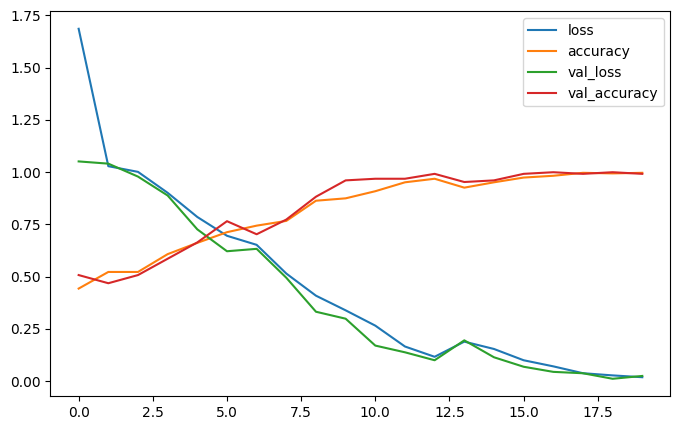

In [41]:
pd.DataFrame(hist.history).plot(figsize=(8,5))

plt.legend()
plt.show()

In [70]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [71]:
for batch in test.as_numpy_iterator():
    X, y = batch
    print("X: ", len(X))
    yhat = model.predict(X)
    print("abc: ", y)
    y_pred = np.argmax(yhat,axis=1)
    print("Predicted: ", y_pred)
    pre.update_state(y,y_pred)
    re.update_state(y,y_pred)
    acc.update_state(y,y_pred)

2023-12-19 15:49:18.611486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:49:18.672716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-12-19 15:49:18.785066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-12-19 15:49:18.819489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


X:  1
1/1 [==============================] - 0s 18ms/step
abc:  [2]
Predicted:  [2]


In [72]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


In [33]:
img = cv2.imread(os.path.join('emotion_data','Sad','360_F_601507482_RbV0Vk2KSg72LkjkSZBJNpmxu6Y4Hdzw.jpg'))
img.shape

(360, 540, 3)

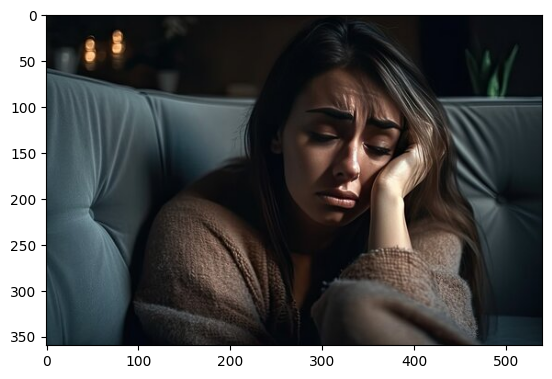

In [34]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

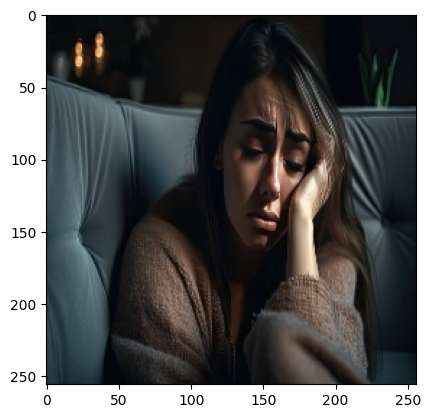

In [35]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize_img = tf.image.resize(img_rgb, (256, 256))
resize_img_np = resize_img.numpy().astype(int)

plt.imshow(resize_img_np)

In [36]:
new_data = np.expand_dims(resize_img_np/255,0) # Add Extra Dim to Img & Normalize Img
yhat = model.predict(new_data) 

1/1 [==============================] - 0s 30ms/step


In [37]:
yhat

array([[1.4067064e-04, 9.2988973e-03, 9.9056047e-01]], dtype=float32)

In [22]:
# CLASS 0 - Happy People
# CLASS 1 - Neutral People
# CLASS 2 - Sad People
def pred_emotion(value):
    pred = np.argmax(value,axis=1)
    print("Value: ", value)
    if pred == 0:
        print('Person is Happy')
    elif pred == 1:
        print('Persion is Neutral')
    else:
        print('Person is Sad')


# Save Model

In [6]:
from tensorflow.keras.models import load_model

In [40]:
model.save(os.path.join('models','emotionmodel.h5'))

/home/krish/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
model = load_model('models/emotionmodel.h5')

In [66]:
imgdata = os.path.join('test',"happy.jpeg")
imgdata

'test/happy.jpeg'

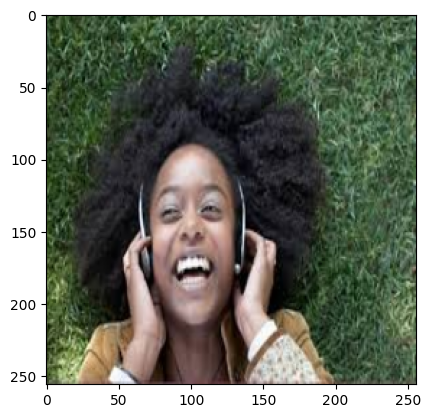

In [68]:
image = cv2.imread(imgdata)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resize_img = tf.image.resize(img_rgb, (256, 256))
resize_img_np = resize_img.numpy().astype(int)

plt.imshow(resize_img_np)

In [69]:
pred = model.predict(np.expand_dims(resize_img/255,0))
pred_emotion(pred)

1/1 [==============================] - 0s 24ms/step
Value:  [[9.8087078e-01 4.0178775e-04 1.8727455e-02]]
Person is Happy


In [ ]:
# CLASS 0 - Happy People
# CLASS 1 - Neutral People
# CLASS 2 - Sad People